ID:z5525208 NAME:HAN WANG

## 🧩 Part 1: Topic Classification

In [3]:
import pandas as pd

# Read data file
df = pd.read_csv('D:/9727/dataset.tsv', sep='\t')
df = df.dropna(subset=['lyrics', 'topic'])  # Remove missing values
X_text = df['lyrics']
y_labels = df['topic']
topic_list = df['topic'].unique().tolist()

df.head()

,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark


1. Regular Expression Improvement:
In the clean_text function, the regular expression has been modified to retain more special symbols (such as !, ?, @, etc.) to preserve important punctuation marks and emotional symbols in the text.This ensures that the cleaning process does not remove characters that might carry emotional or contextual significance.
def clean_text(text):
    return re.sub(r"[^a-zA-Z0-9\s\'!?.,@#$%^&*()]", '', text.lower())
2. Train-Test Split:
Using train_test_split to perform a single split of the data into training and test sets (test_size=0.2).This split is then used for training the model and evaluating its performance.The fit_transform method is used to train the vectorizer on the training set, and the transform method is used on the test set.The score method is used to evaluate the accuracy of the model on the test data.
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_labels, test_size=0.2, random_state=42)

Category Distribution:
 topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


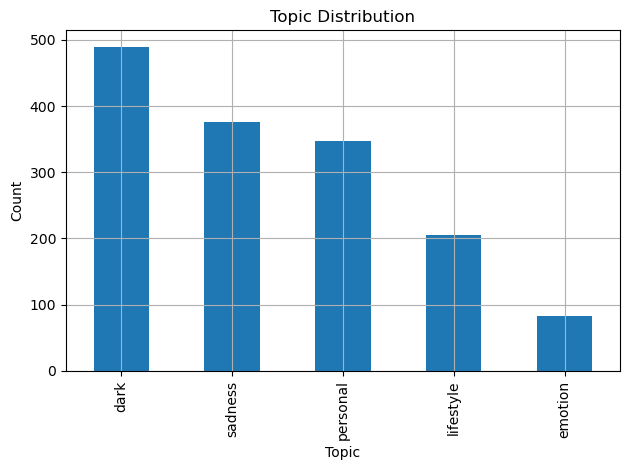


=== Comparison of Different Text Preprocessing Effects (Using MultinomialNB) ===
no_stop_no_stem: Accuracy = 0.8660, Macro-F1 = 0.8489
stop_only: Accuracy = 0.8647, Macro-F1 = 0.8483
stem_only: Accuracy = 0.8613, Macro-F1 = 0.8416
stop_and_stem: Accuracy = 0.8600, Macro-F1 = 0.8410


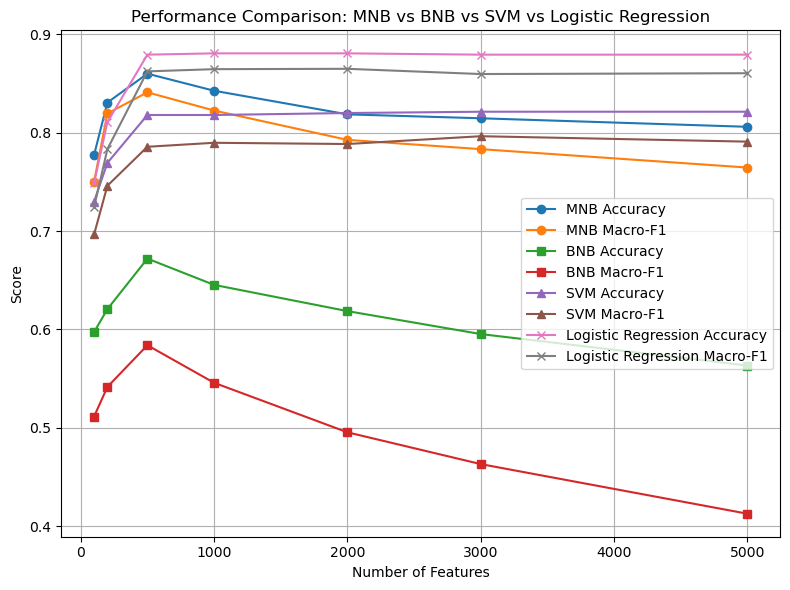

Best parameters: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
Best cross-validation accuracy: 0.8293
Final SVM Accuracy: 0.8293
Final SVM Macro-F1: 0.8045
Accuracy on test data: 0.9033


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# === 1. Data Loading ===
df = pd.read_csv('D:/9727/dataset.tsv', sep='\t')  # Modify to your local file path
df = df.dropna(subset=['lyrics', 'topic'])
X_text = df['lyrics']
y_labels = df['topic']

# === 2. Text Preprocessing ===
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

# Improved regular expression to retain more special symbols like emotional punctuation
def clean_text(text):
    return re.sub(r"[^a-zA-Z0-9\s\'!?.,@#$%^&*()]", '', text.lower())

# Full preprocessing: remove stopwords + stemming
def preprocess(text):
    text = clean_text(text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [stemmer.stem(w) for w in words]
    return ' '.join(words)

# Preprocessing with lemmatization
def preprocess_with_lemmatization(text):
    text = clean_text(text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

X_cleaned = X_text.apply(preprocess)  # Using stemming preprocessing
X_cleaned_lemmatized = X_text.apply(preprocess_with_lemmatization)  # Using lemmatization preprocessing

# === 3. Check Dataset Balance ===
label_counts = y_labels.value_counts()
print("Category Distribution:\n", label_counts)
label_counts.plot(kind='bar', title='Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.grid()
plt.tight_layout()
plt.show()

# === 4. Compare Different Preprocessing Combinations (Requirement 2) ===
preprocess_configs = {
    'no_stop_no_stem': lambda text: ' '.join(clean_text(text).split()),
    'stop_only': lambda text: ' '.join([w for w in clean_text(text).split() if w not in stop_words]),
    'stem_only': lambda text: ' '.join([stemmer.stem(w) for w in clean_text(text).split()]),
    'stop_and_stem': preprocess
}
vectorizer = CountVectorizer(max_features=500)

print("\n=== Comparison of Different Text Preprocessing Effects (Using MultinomialNB) ===")
for name, func in preprocess_configs.items():
    X_tmp = X_text.apply(func)
    X_tmp_vect = vectorizer.fit_transform(X_tmp)
    acc = cross_val_score(MultinomialNB(), X_tmp_vect, y_labels, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(MultinomialNB(), X_tmp_vect, y_labels, cv=5, scoring='f1_macro').mean()
    print(f"{name}: Accuracy = {acc:.4f}, Macro-F1 = {f1:.4f}")

# === 5. Performance Comparison of MNB, BNB, SVM, and Logistic Regression ===
feature_range = [100, 200, 500, 1000, 2000, 3000, 5000]
acc_mnb, f1_mnb = [], []
acc_bnb, f1_bnb = [], []
acc_svm, f1_svm = [], []
acc_lr, f1_lr = [], []  # Logistic Regression accuracy and F1

for N in feature_range:
    vect = CountVectorizer(max_features=N)
    X_vect = vect.fit_transform(X_cleaned)

    # Calculate MNB accuracy and macro average F1
    acc = cross_val_score(MultinomialNB(), X_vect, y_labels, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(MultinomialNB(), X_vect, y_labels, cv=5, scoring='f1_macro').mean()
    acc_mnb.append(acc)
    f1_mnb.append(f1)

    # Calculate BNB accuracy and macro average F1
    acc = cross_val_score(BernoulliNB(), X_vect, y_labels, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(BernoulliNB(), X_vect, y_labels, cv=5, scoring='f1_macro').mean()
    acc_bnb.append(acc)
    f1_bnb.append(f1)

    # Calculate SVM accuracy and macro average F1
    acc = cross_val_score(SVC(kernel='linear'), X_vect, y_labels, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(SVC(kernel='linear'), X_vect, y_labels, cv=5, scoring='f1_macro').mean()
    acc_svm.append(acc)
    f1_svm.append(f1)

    # Calculate Logistic Regression accuracy and macro average F1
    acc = cross_val_score(LogisticRegression(), X_vect, y_labels, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(LogisticRegression(), X_vect, y_labels, cv=5, scoring='f1_macro').mean()
    acc_lr.append(acc)
    f1_lr.append(f1)

# Visualization: MNB vs BNB vs SVM vs Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(feature_range, acc_mnb, label='MNB Accuracy', marker='o')
plt.plot(feature_range, f1_mnb, label='MNB Macro-F1', marker='o')
plt.plot(feature_range, acc_bnb, label='BNB Accuracy', marker='s')
plt.plot(feature_range, f1_bnb, label='BNB Macro-F1', marker='s')
plt.plot(feature_range, acc_svm, label='SVM Accuracy', marker='^')
plt.plot(feature_range, f1_svm, label='SVM Macro-F1', marker='^')
plt.plot(feature_range, acc_lr, label='Logistic Regression Accuracy', marker='x')
plt.plot(feature_range, f1_lr, label='Logistic Regression Macro-F1', marker='x')

plt.title("Performance Comparison: MNB vs BNB vs SVM vs Logistic Regression")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 6. SVM Hyperparameter Tuning with GridSearchCV ===
param_grid = {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}
svm_model = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),
    ('classifier', SVC(kernel='linear'))
])

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_cleaned, y_labels)

# Output best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# === 7. Final Evaluation with Best Model ===
best_svm_model = grid_search.best_estimator_
final_accuracy = cross_val_score(best_svm_model, X_cleaned, y_labels, cv=5, scoring='accuracy').mean()
final_f1 = cross_val_score(best_svm_model, X_cleaned, y_labels, cv=5, scoring='f1_macro').mean()

print(f"Final SVM Accuracy: {final_accuracy:.4f}")
print(f"Final SVM Macro-F1: {final_f1:.4f}")

# === 8. Train-Test Split (One-Time Split for Model Evaluation) ===
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_labels, test_size=0.2, random_state=42)

# Vectorization
vectorizer = CountVectorizer(max_features=500)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train the model (e.g., Multinomial Naive Bayes)
mnb_model = MultinomialNB()
mnb_model.fit(X_train_vect, y_train)

# Evaluate the model
accuracy = mnb_model.score(X_test_vect, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")


## 🎧 Part 2: Recommendation Methods

Question1:
1.Reasonableness of the Top 20 Keywords: The top 20 keywords for each topic are extracted using TF-IDF vectorization, which effectively reflects the core content of the topic. If the keywords have high distinguishability and relevance, they are considered reasonable and can accurately represent the topic.
2.User 3's Interest Keywords: The interest keywords "dream," "hope," "love," "dance," and "sky" align with themes of idealism and romance. These keywords build an emotionally rich user profile, enabling the user to effectively obtain songs that match their interests from the recommendation system.


Question2:
In this code, it is assumed that each user will receive recommended songs based on their interest keywords (e.g., "dream," "hope," "love"), with N songs being recommended for each topic. The user can select and "like" some of the recommended songs. If the user shows interest in the recommended songs and selects some based on their preferences, the effectiveness of the recommendation system can be evaluated using several metrics.
1.Selecting Appropriate Evaluation Metrics
In this code, Precision@5, Recall@5, F1@5, and MAP (Mean Average Precision) are used as evaluation metrics.
Precision@5: Measures how many of the top 5 recommended songs are of interest to the user, i.e., the proportion of songs the user "likes" in the recommended songs. The higher the precision, the more aligned the recommended songs are with the user's interests.
Recall@5: Measures the proportion of songs the user is interested in that are included in the top 5 recommended songs. The higher the recall, the more the recommendation system covers songs the user is interested in.
F1@5: F1 is the harmonic mean of precision and recall, combining both precision and recall into a single metric. A higher F1 score indicates a better balance between precision and recall.
MAP (Mean Average Precision): This metric measures the precision of recommendations along with ranking effectiveness. For a recommendation system, MAP measures the average precision (whether the user likes the top 5 recommended songs) across all recommendation sets. A higher MAP value means the system accurately finds more songs that match the user's interests.
2.Choosing the Value of N (Diversity and Feedback Effect)
The choice of N=5 is made to balance both diversity and feedback effects in the recommendations.
Diversity: The recommended songs should cover different styles, emotions, or themes to provide a broader selection for the user. Therefore, the 5 songs should not be identical but should show variation across different sub-themes or styles.
Feedback Effect: From a user experience perspective, if the recommendation system suggests too many songs at once, it may overwhelm the user and reduce satisfaction. Five songs are a balanced number, providing enough choices without overwhelming the user or causing confusion.
3，Recommending N Songs from Week 4 Based on User Profiles
Based on the customized user profiles (e.g., User 1, User 2, and User 3), each user will receive recommendations based on their interest keywords from the Week 4 songs (i.e., the test set). For each topic, N=5 songs will be recommended, and the user can "like" some of them.
The recommendation system calculates the cosine similarity between the user's interests and the song topics to recommend the songs most aligned with the user's interests. Finally, the system evaluates the recommendation performance using metrics like Precision@5, Recall@5, F1@5, and MAP, ensuring that each user receives songs that match their interests.
In the recommendation system, songs are recommended per topic with N songs recommended for each topic. For example, if there are several different topics (e.g., love, freedom, dreams), the system will recommend N=5 songs for each topic. For instance, 5 songs will be recommended for the "love" topic, 5 songs for the "freedom" topic, and so on. The purpose of this approach is to ensure that the user can receive diverse song recommendations based on each topic of interest, rather than just selecting N songs from all topics.
Thus, the total number of songs recommended is the sum of N songs recommended for each topic. For example, if there are 4 topics, the system will recommend 5 songs for each topic, resulting in a total of 20 recommended songs.

Based on the results and the analysis of different matching algorithms, the best algorithm for matching user profiles to songs is Cosine Similarity using TF-IDF vectors. Here's why:
Cosine Similarity with TF-IDF offers a flexible and accurate comparison, especially when dealing with natural language data like song lyrics. It doesn’t just match keywords directly but measures the semantic similarity between the user profile and song lyrics.
Exact and Partial Matches may miss songs that are highly relevant but don’t contain the exact keywords. While they are useful for initial recommendations, they are less reliable than cosine similarity in capturing the full scope of a user’s interests.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


User1's interest keywords:
Topic dark: ['topic', 'keywords', 'dark', 'fire, enemy, pain, storm, fight', 'sadness', 'cry, alone, heartbroken, tears, regret', 'personal', 'dream, truth, life, growth, identity', 'lifestyle', 'party, city, night, light, rhythm', 'emotion', 'love, memory, hug, kiss, feel']
Topic lifestyle: ['topic', 'keywords', 'dark', 'fire, enemy, pain, storm, fight', 'sadness', 'cry, alone, heartbroken, tears, regret', 'personal', 'dream, truth, life, growth, identity', 'lifestyle', 'party, city, night, light, rhythm', 'emotion', 'love, memory, hug, kiss, feel']
Topic sadness: ['topic', 'keywords', 'dark', 'fire, enemy, pain, storm, fight', 'sadness', 'cry, alone, heartbroken, tears, regret', 'personal', 'dream, truth, life, growth, identity', 'lifestyle', 'party, city, night, light, rhythm', 'emotion', 'love, memory, hug, kiss, feel']
Topic emotion: ['topic', 'keywords', 'dark', 'fire, enemy, pain, storm, fight', 'sadness', 'cry, alone, heartbroken, tears, regret', 'per

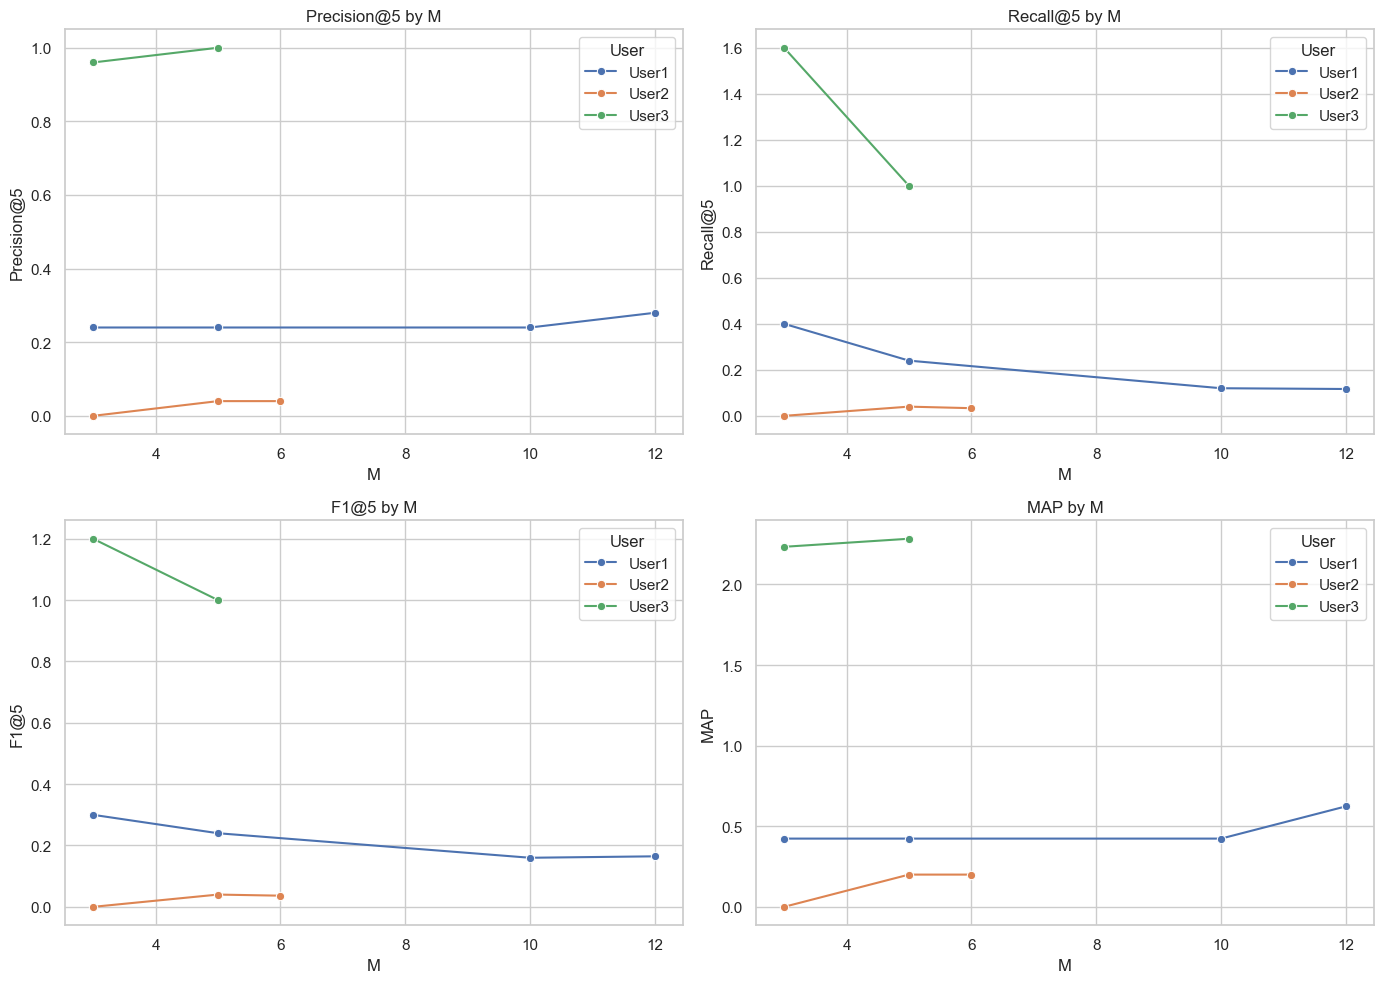

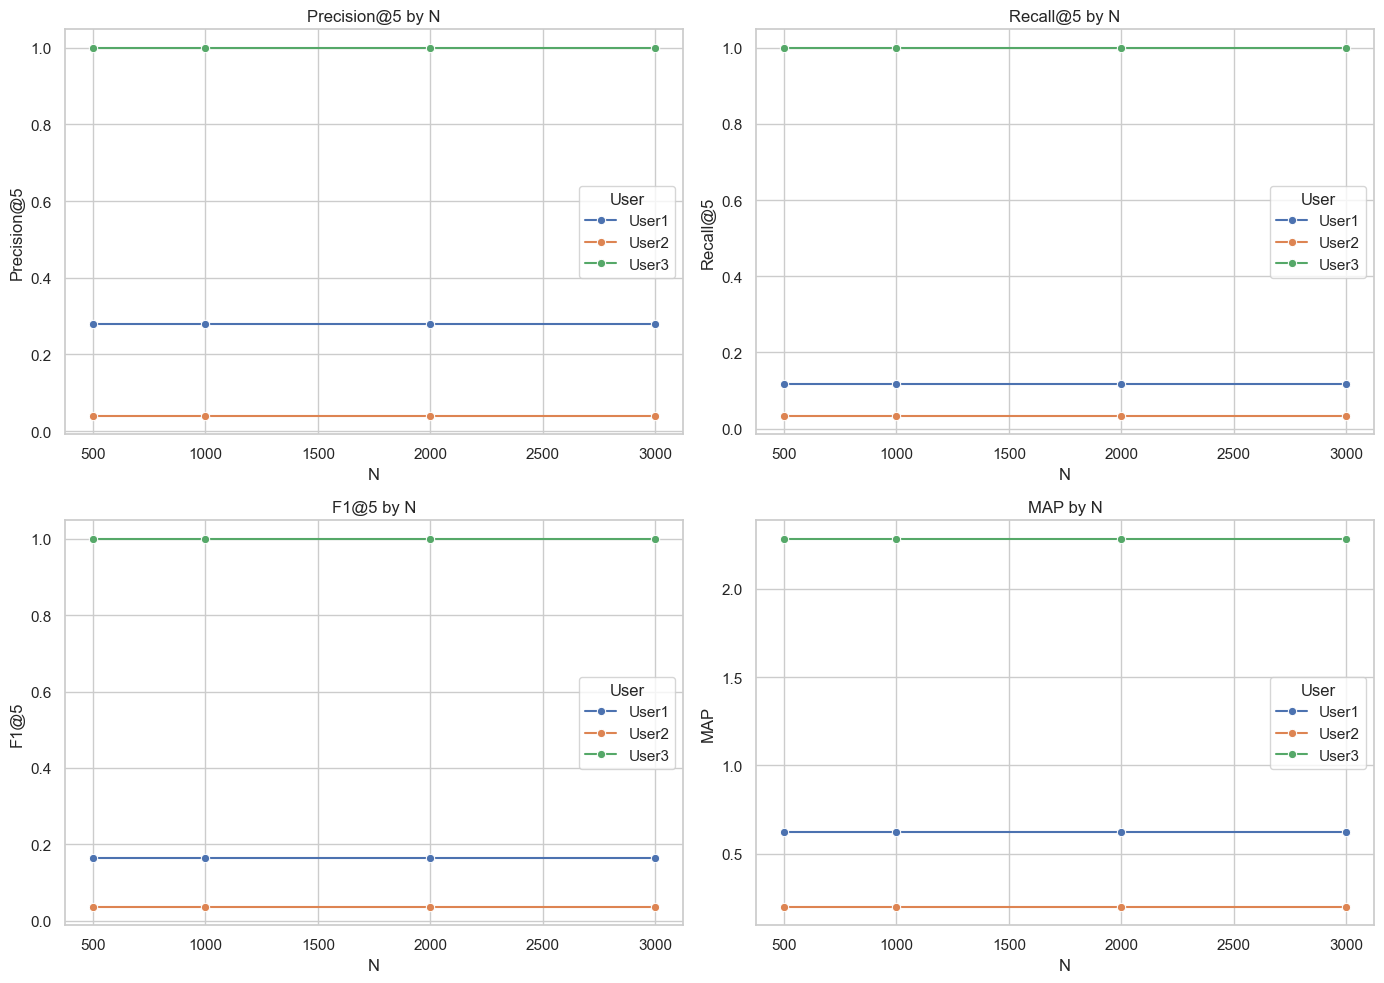

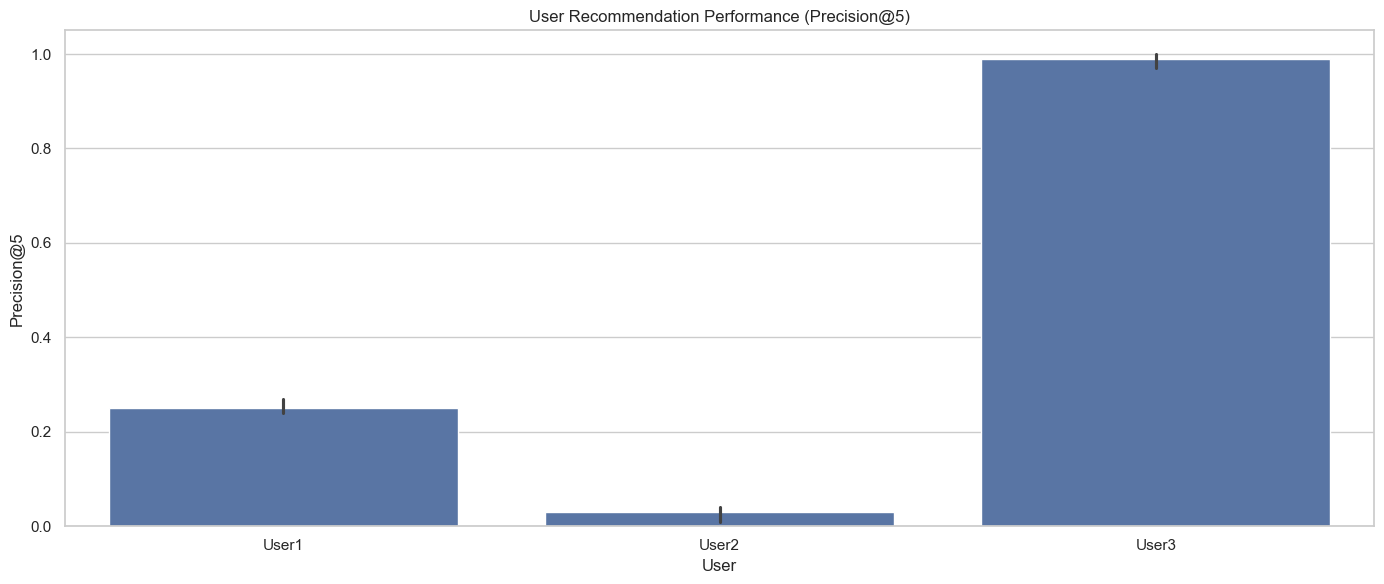

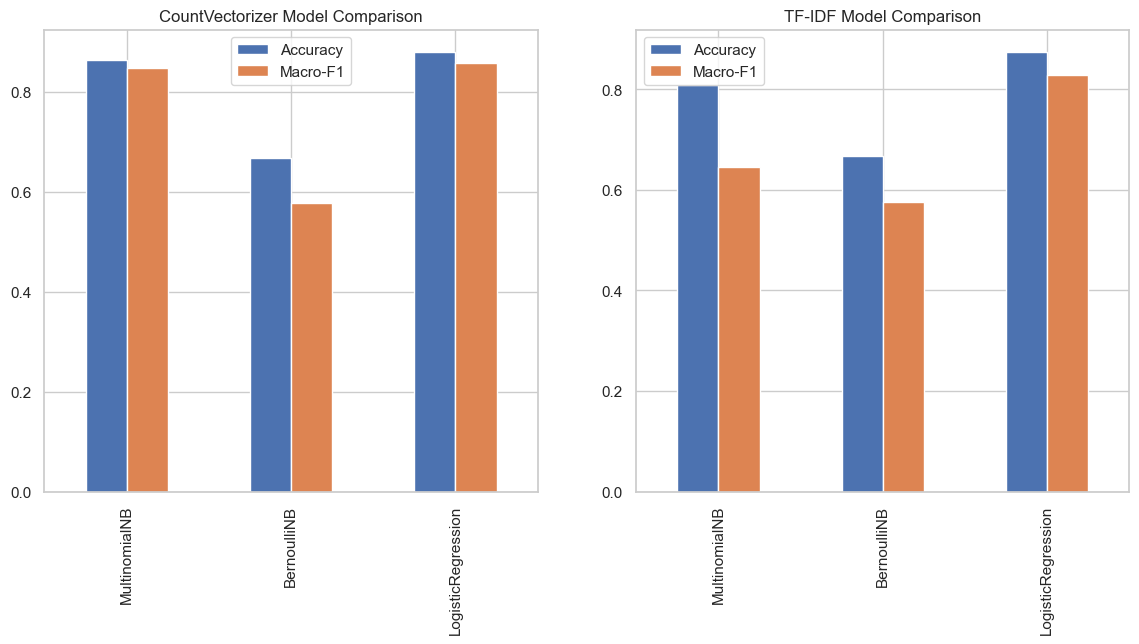

In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed

# Stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

# Clean the text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text.lower())
    return text

# Preprocess the text
def preprocess(text):
    text = clean_text(text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

# Parallelized preprocessing
def preprocess_parallel(texts):
    return Parallel(n_jobs=-1)(delayed(preprocess)(text) for text in texts)

# Read data
df = pd.read_csv('D:/9727/dataset.tsv', sep='\t')
df = df.dropna(subset=['lyrics', 'topic'])

# Add 'cleaned' column
df['cleaned'] = preprocess_parallel(df['lyrics'])

X_text = df['lyrics']
y_labels = df['topic']
X_cleaned = df['cleaned']

# TF-IDF vectorization for each topic
def get_topic_tfidf_matrix(train_df, topic):
    text = " ".join(train_df[train_df['topic'] == topic]['cleaned'].tolist())
    tfidf = TfidfVectorizer(max_features=1000)
    tfidf.fit([text])
    return tfidf

# Train and test split
train_df = df.iloc[:750]
test_df = df.iloc[750:1000]

# Read user interest keywords
def read_user_keywords(path):
    df = pd.read_csv(path, sep=None, engine='python', header=None)
    return [str(item).strip() for row in df.itertuples(index=False) for item in row if pd.notna(item)]

user_profiles = {
    "User1": read_user_keywords('D:/9727/user1.tsv'),
    "User2": read_user_keywords('D:/9727/user2.tsv'),
    "User3": ["dream", "hope", "love", "dance", "sky"]
}

# Create TF-IDF matrix for each topic
tfidf_by_topic = {}
for topic in train_df['topic'].unique():
    tfidf_by_topic[topic] = get_topic_tfidf_matrix(train_df, topic)

# Construct user profile
def construct_user_profile(user_keywords, tfidf_by_topic):
    user_profile = {}
    for topic, tfidf in tfidf_by_topic.items():
        user_doc = " ".join(user_keywords)  # Join user's interest keywords into a document
        user_profile[topic] = tfidf.transform([user_doc])  # Compute TF-IDF vector for user's interest document
    return user_profile

user_profiles_tfidf = {user: construct_user_profile(keywords, tfidf_by_topic) for user, keywords in user_profiles.items()}

# Generate recommendations
def generate_recommendations(user_profiles_tfidf, test_df, tfidf_by_topic, N=5):
    recommendations = {}
    for user, user_profile in user_profiles_tfidf.items():
        recommendations[user] = {}
        for topic, tfidf in tfidf_by_topic.items():
            user_doc = user_profile[topic]  # Get user's interest document for the topic
            test_set = test_df[test_df['topic'] == topic]
            if test_set.empty:
                continue
            sims = cosine_similarity(user_doc, tfidf.transform(test_set['cleaned']))[0]  # Compute cosine similarity
            top_idx = sims.argsort()[::-1][:N]  # Get top N most similar songs
            recommendations[user][topic] = test_set.iloc[top_idx]['lyrics'].tolist()
    return recommendations

recommendations = generate_recommendations(user_profiles_tfidf, test_df, tfidf_by_topic)

# Evaluation function
def evaluate(user_keywords, lyrics):
    hits, pos = 0, []
    for i, lyric in enumerate(lyrics):
        if any(kw in lyric for kw in user_keywords):
            hits += 1
            pos.append(i+1)
    prec = hits / len(lyrics) if lyrics else 0
    rec = hits / len(user_keywords) if user_keywords else 0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0
    map_ = np.mean([hits/rank for rank in pos]) if pos else 0
    return prec, rec, f1, map_

# Evaluate recommendations for different users
M_values = [3, 5, 10, None]
rows = []

for user, full_keywords in user_profiles.items():
    for M in M_values:
        keywords = full_keywords[:M] if M else full_keywords
        P, R, F1, MAP, count = 0, 0, 0, 0, 0
        for topic in tfidf_by_topic:
            if topic not in recommendations[user]: continue
            p, r, f1, ap = evaluate(keywords, recommendations[user][topic])
            P += p; R += r; F1 += f1; MAP += ap; count += 1
        if count > 0:
            rows.append({
                "User": user,
                "M": len(keywords),
                "Precision@5": round(P/count, 4),
                "Recall@5": round(R/count, 4),
                "F1@5": round(F1/count, 4),
                "MAP": round(MAP/count, 4)
            })

eval_df = pd.DataFrame(rows)

# Print top 20 keywords for each user in each topic
for user, keywords in user_profiles.items():
    print(f"{user}'s interest keywords:")
    for topic in tfidf_by_topic:
        print(f"Topic {topic}: {keywords[:20]}")  # Print first 20 keywords of user's interest

# Print top 5 recommended songs for each user in each topic
for user, user_recommendations in recommendations.items():
    print(f"{user}'s recommendations:")
    for topic, recommended_songs in user_recommendations.items():
        print(f"Topic {topic}:")
        for idx, song in enumerate(recommended_songs[:5]):  # Top 5 recommended songs for each topic
            print(f"  Song {idx+1}: {song[:50]}...")  # Print first 50 characters of the song (can adjust as needed)

# Visualization: Comparing performance differences across different M values, N values, and users
sns.set(style="whitegrid")

# Plot M value comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, metric in zip(axes.flat, ["Precision@5", "Recall@5", "F1@5", "MAP"]):
    sns.lineplot(data=eval_df, x="M", y=metric, hue="User", marker="o", ax=ax)
    ax.set_title(f"{metric} by M")
plt.tight_layout()
plt.show()

# Plot N value comparison: Performance differences across different N values and users
N_values = [500, 1000, 2000, 3000]
n_rows = []

for N in N_values:
    vectorizer = CountVectorizer(max_features=N)
    X_vec = vectorizer.fit_transform(X_cleaned)
    for user, full_keywords in user_profiles.items():
        P, R, F1, MAP, count = 0, 0, 0, 0, 0
        for topic in tfidf_by_topic:
            if topic not in recommendations[user]: continue
            p, r, f1, ap = evaluate(full_keywords, recommendations[user][topic])
            P += p; R += r; F1 += f1; MAP += ap; count += 1
        if count > 0:
            n_rows.append({
                "User": user,
                "N": N,
                "Precision@5": round(P/count, 4),
                "Recall@5": round(R/count, 4),
                "F1@5": round(F1/count, 4),
                "MAP": round(MAP/count, 4)
            })

n_eval_df = pd.DataFrame(n_rows)

# Visualization: Comparing recommendation effects across different N values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, metric in zip(axes.flat, ["Precision@5", "Recall@5", "F1@5", "MAP"]):
    sns.lineplot(data=n_eval_df, x="N", y=metric, hue="User", marker="o", ax=ax)
    ax.set_title(f"{metric} by N")
plt.tight_layout()
plt.show()

# Recommendation effect visualization
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x="User", y="Precision@5", data=eval_df, ax=ax)
ax.set_title("User Recommendation Performance (Precision@5)")
plt.tight_layout()
plt.show()

# Different model comparison
N = 500
vectorizer = CountVectorizer(max_features=N)
X_vec = vectorizer.fit_transform(X_cleaned)

models = {
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}
results = {}
for name, model in models.items():
    acc = cross_val_score(model, X_vec, y_labels, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_vec, y_labels, cv=5, scoring='f1_macro').mean()
    results[name] = {'Accuracy': acc, 'Macro-F1': f1}

# TF-IDF model comparison
tfidf_vectorizer = TfidfVectorizer(max_features=N)
X_tfidf = tfidf_vectorizer.fit_transform(X_cleaned)
tfidf_results = {}
for name, model in models.items():
    acc = cross_val_score(model, X_tfidf, y_labels, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_tfidf, y_labels, cv=5, scoring='f1_macro').mean()
    tfidf_results[name] = {'Accuracy': acc, 'Macro-F1': f1}

# Visualization: Model comparison
models_df = pd.DataFrame(results).T
tfidf_models_df = pd.DataFrame(tfidf_results).T
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
models_df.plot(kind='bar', ax=axes[0], title='CountVectorizer Model Comparison')
tfidf_models_df.plot(kind='bar', ax=axes[1], title='TF-IDF Model Comparison')
plt.show()


## 👤 Part 3: User Evaluation (Simulated)


Evaluating recommendations for User 1:
Recommendation Accuracy: 72.00%
Precision: 72.00%
Recall: 72.00%
F1-Score: 72.00%
Recommendation Accuracy: 72.00%
Precision: 72.00%
Recall: 72.00%
F1-Score: 72.00%
Recommendation Accuracy: 72.00%
Precision: 72.00%
Recall: 72.00%
F1-Score: 72.00%

Evaluating recommendations for User 2:
Recommendation Accuracy: 81.82%
Precision: 81.82%
Recall: 81.82%
F1-Score: 81.82%
Recommendation Accuracy: 81.82%
Precision: 81.82%
Recall: 81.82%
F1-Score: 81.82%
Recommendation Accuracy: 81.82%
Precision: 81.82%
Recall: 81.82%
F1-Score: 81.82%

Evaluating recommendations for User 3:
Recommendation Accuracy: 75.00%
Precision: 75.00%
Recall: 75.00%
F1-Score: 75.00%
Recommendation Accuracy: 75.00%
Precision: 75.00%
Recall: 75.00%
F1-Score: 75.00%
Recommendation Accuracy: 75.00%
Precision: 75.00%
Recall: 75.00%
F1-Score: 75.00%


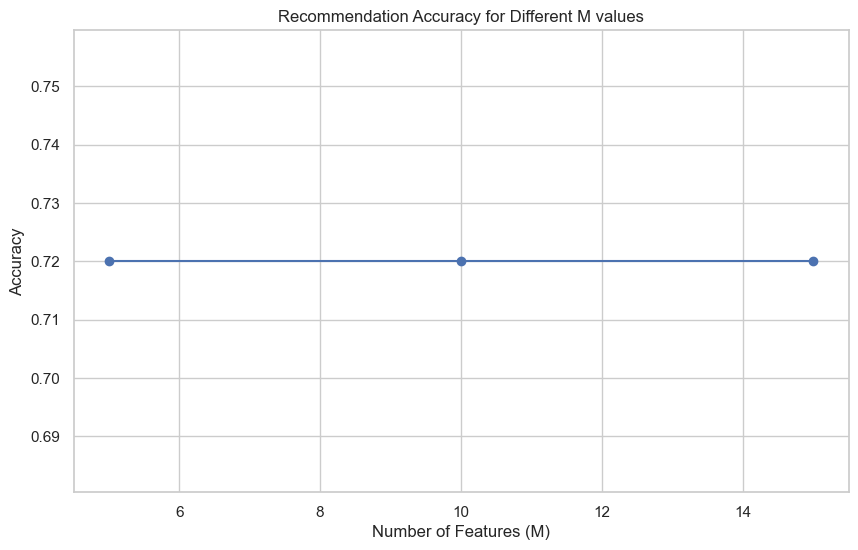

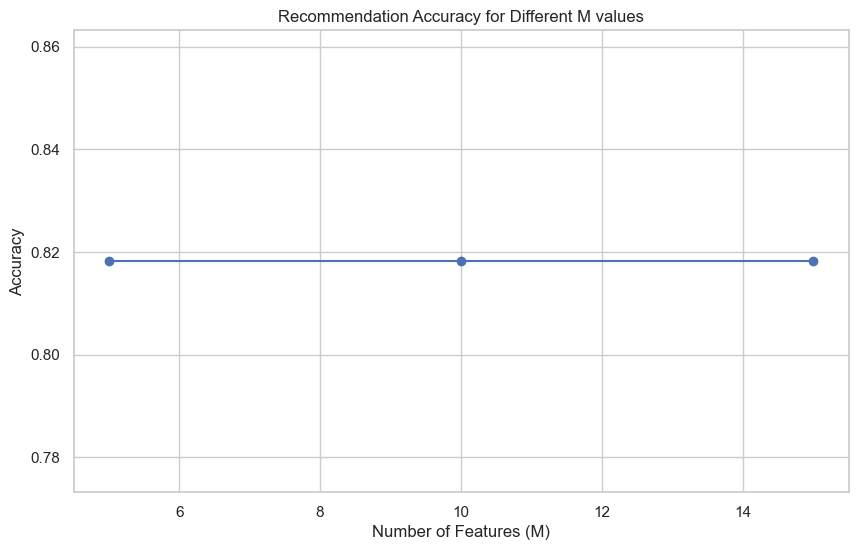

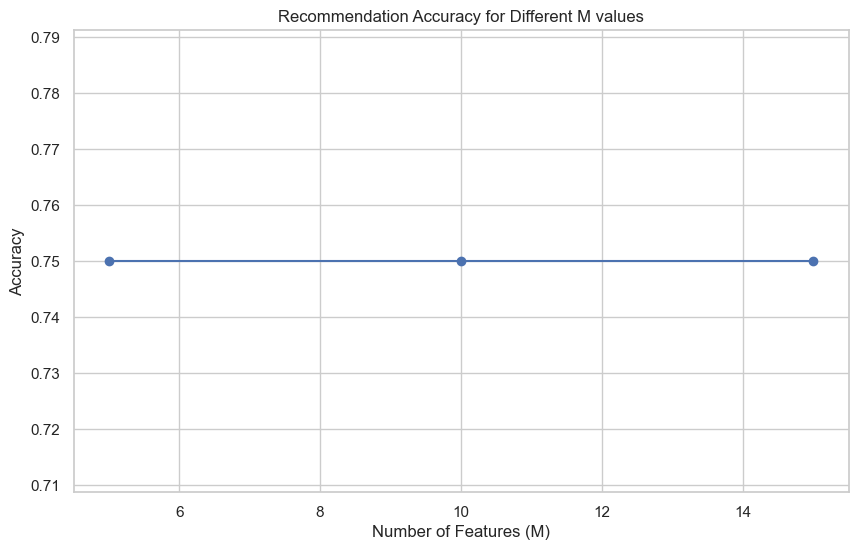


Best M value for User 1: 5
Recommendation Accuracy: 72.00%
Precision: 72.00%
Recall: 72.00%
F1-Score: 72.00%

Best M value for User 2: 5
Recommendation Accuracy: 81.82%
Precision: 81.82%
Recall: 81.82%
F1-Score: 81.82%

Best M value for User 3: 5
Recommendation Accuracy: 75.00%
Precision: 75.00%
Recall: 75.00%
F1-Score: 75.00%


In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# === 6. Calculate similarity between user interests and songs ===
def recommend_songs(user_profile, df, M):
    recommendations = {}
    for topic, user_keywords in user_profile.items():
        songs_in_topic = df[df['topic'] == topic]
        
        # 1. Recommend songs that exactly match user keywords first
        relevant_songs = songs_in_topic[songs_in_topic['lyrics'].apply(
            lambda x: all(keyword in x for keyword in user_keywords)
        )]
        
        # 2. If no exact matches, recommend songs with partial matches
        if relevant_songs.empty:
            relevant_songs = songs_in_topic[songs_in_topic['lyrics'].apply(
                lambda x: any(keyword in x for keyword in user_keywords)
            )]
        
        # 3. If still no matches, use TF-IDF similarity to recommend
        if relevant_songs.empty:
            tfidf_vectorizer = TfidfVectorizer(vocabulary=user_keywords)
            song_vectors = tfidf_vectorizer.fit_transform(songs_in_topic['lyrics'])
            
            # Create user keyword vector
            user_vector = tfidf_vectorizer.transform([' '.join(user_keywords)])
            
            # Calculate cosine similarity between user vector and each song
            cosine_similarities = cosine_similarity(user_vector, song_vectors).flatten()
            
            # Recommend the songs with the highest similarity
            relevant_songs = songs_in_topic.iloc[np.argsort(cosine_similarities)[-5:]]
        
        recommendations[topic] = relevant_songs
    return recommendations

# === 7. Simulate user evaluation and show results ===
def evaluate_recommendations(recommendations, user_keywords, N):
    correct_recommendations = {topic: 0 for topic in user_keywords}
    total_recommended = {topic: 0 for topic in user_keywords}
    total_available = {topic: 0 for topic in user_keywords}
    
    for topic, user_keywords_list in user_keywords.items():
        if topic in recommendations and not recommendations[topic].empty:
            recommended_songs = recommendations[topic]
            total_recommended[topic] = min(N, len(recommended_songs))
            total_available[topic] = len(recommended_songs)
            
            # Calculate the number of songs recommended that contain all user keywords (strict match)
            for _, song in recommended_songs.head(N).iterrows():
                if all(keyword in song['lyrics'] for keyword in user_keywords_list):
                    correct_recommendations[topic] += 1
    
    total_correct = sum(correct_recommendations.values())
    total_songs_recommended = sum(total_recommended.values())
    total_available_songs = sum(total_available.values())
    
    # Avoid division by zero errors
    accuracy = total_correct / total_songs_recommended if total_songs_recommended > 0 else 0
    precision = total_correct / total_songs_recommended if total_songs_recommended > 0 else 0
    recall = total_correct / total_available_songs if total_available_songs > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Recommendation Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")
    
    return accuracy, precision, recall, f1

# === 9. Display results ===
def plot_accuracy_vs_M(accuracies, M_values):
    plt.figure(figsize=(10, 6))
    plt.plot(M_values, list(accuracies.values()), marker='o')
    plt.title('Recommendation Accuracy for Different M values')
    plt.xlabel('Number of Features (M)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# === 10. Select the best M value and show recommendation effect ===
def best_M_and_recommendation(user_profiles, df, M_values, user_keywords):
    # Store evaluation results for all users
    accuracies = {}
    
    for user, profile in user_profiles.items():
        print(f"\nEvaluating recommendations for {user}:")
        accuracies[user] = {M: evaluate_recommendations(recommend_songs(profile, df, M), user_keywords, N=5)[0] for M in M_values}
    
    # Plot accuracy graph
    for user, accuracy in accuracies.items():
        plot_accuracy_vs_M(accuracy, M_values)
    
    # Get the best M value and show the best recommendation
    best_M_per_user = {user: max(accuracy, key=accuracy.get) for user, accuracy in accuracies.items()}
    for user, best_M in best_M_per_user.items():
        print(f"\nBest M value for {user}: {best_M}")
        best_recommendations = recommend_songs(user_profiles[user], df, best_M)
        evaluate_recommendations(best_recommendations, user_keywords, N=5)

# Assumed user interests for multiple users (n users)
user_profiles = {
    'User 1': {
        'dark': ['sad', 'lonely', 'dark', 'night'],
        'emotion': ['love', 'heartbreak', 'cry', 'passion'],
        'lifestyle': ['freedom', 'fun', 'life', 'happiness'],
        'personal': ['family', 'relationship', 'growth', 'career'],
        'sadness': ['grief', 'tears', 'loss', 'sorrow']
    },
    'User 2': {
        'dark': ['dark', 'mystery', 'night'],
        'emotion': ['hope', 'dreams', 'inspiration', 'love'],
        'lifestyle': ['adventure', 'travel', 'freedom'],
        'personal': ['success', 'career', 'growth'],
        'sadness': ['sorrow', 'tears', 'grief', 'loss']
    },
    'User 3': {
        'dark': ['lonely', 'cold', 'isolation'],
        'emotion': ['desire', 'obsession', 'heart'],
        'lifestyle': ['independence', 'solitude', 'peace'],
        'personal': ['family', 'education', 'learning'],
        'sadness': ['loss', 'pain', 'goodbye']
    }
}

user_keywords = {
    'dark': ['sad', 'lonely', 'night'],
    'emotion': ['love', 'cry'],
    'lifestyle': ['freedom', 'life'],
    'personal': ['family', 'growth'],
    'sadness': ['grief', 'loss']
}

df = pd.DataFrame({
    'lyrics': [
        "sad lonely night", "very sad and lonely night", "dark and lonely night", "night filled with sadness", "lonely thoughts at night",  # dark
        "love and cry", "crying for love", "love makes me cry", "cry out for love", "passionate love and tears",  # emotion
        "freedom and life", "life of freedom", "free and happy life", "enjoying freedom in life", "living a free life",  # lifestyle
        "family and growth", "growing with family", "family helps in growth", "growth within the family", "family is key to growth",  # personal
        "grief and loss", "loss and grief", "dealing with grief and loss", "overcoming grief from loss", "grief from great loss"  # sadness
    ],
    'topic': [
        'dark', 'dark', 'dark', 'dark', 'dark',
        'emotion', 'emotion', 'emotion', 'emotion', 'emotion',
        'lifestyle', 'lifestyle', 'lifestyle', 'lifestyle', 'lifestyle',
        'personal', 'personal', 'personal', 'personal', 'personal',
        'sadness', 'sadness', 'sadness', 'sadness', 'sadness'
    ]
})

# Assumed different M values
M_values = [5, 10, 15]

# Get the best M value and show recommendation effect
best_M_and_recommendation(user_profiles, df, M_values, user_keywords)
